In [26]:
from sklearn.preprocessing import StandardScaler
import joblib
import pandas as pd

In [27]:
data = pd.read_csv('data/train_data.csv')
x = data[['Temperature (°C)','Humidity (%)']]
scaler = StandardScaler()
x_scaled = scaler.fit_transform(x)

joblib.dump(scaler, "models/scaler.pkl")

print(data.head())

                    Timestamp  Temperature (°C)  Humidity (%)
0  2024-10-03 09:31:55.092956         26.420316     62.747896
1  2024-10-03 09:46:55.092956         20.841400     40.737607
2  2024-10-03 10:01:55.092956         21.616287     40.663707
3  2024-10-03 10:16:55.092956         28.985542     49.708307
4  2024-10-03 10:31:55.092956         26.064291     54.659296


One Class Svm:

In [28]:
from sklearn.svm import OneClassSVM

svm = OneClassSVM(kernel='rbf', gamma='scale', nu=0.05, degree=3, cache_size=200)
svm.fit(x_scaled)

joblib.dump(svm, "models/svm.pkl")

svm_predictions = svm.predict(x_scaled)
data['svm predictions'] = svm_predictions
print(data.head())

                    Timestamp  Temperature (°C)  Humidity (%)  svm predictions
0  2024-10-03 09:31:55.092956         26.420316     62.747896                1
1  2024-10-03 09:46:55.092956         20.841400     40.737607                1
2  2024-10-03 10:01:55.092956         21.616287     40.663707                1
3  2024-10-03 10:16:55.092956         28.985542     49.708307                1
4  2024-10-03 10:31:55.092956         26.064291     54.659296                1


Local Outlier Factor:

In [29]:
from sklearn.neighbors import LocalOutlierFactor

lof = LocalOutlierFactor(n_neighbors=35, contamination=0.1, novelty=True, algorithm='auto', p=2)
lof.fit(x_scaled)

joblib.dump(lof, "models/lof.pkl")

lof_predictions = lof.predict(x_scaled)
data['lof predictions'] = lof_predictions
print(data.head())


                    Timestamp  Temperature (°C)  Humidity (%)  \
0  2024-10-03 09:31:55.092956         26.420316     62.747896   
1  2024-10-03 09:46:55.092956         20.841400     40.737607   
2  2024-10-03 10:01:55.092956         21.616287     40.663707   
3  2024-10-03 10:16:55.092956         28.985542     49.708307   
4  2024-10-03 10:31:55.092956         26.064291     54.659296   

   svm predictions  lof predictions  
0                1                1  
1                1                1  
2                1                1  
3                1                1  
4                1                1  


Isolation Forest:

In [30]:
from sklearn.ensemble import IsolationForest

isof = IsolationForest(n_estimators=150, bootstrap=False, warm_start=False)
isof.fit(x_scaled)

joblib.dump(isof, "models/isof.pkl")

isof_predictions = isof.predict(x_scaled)
data['isof predictions'] = isof_predictions
print(data.head())

                    Timestamp  Temperature (°C)  Humidity (%)  \
0  2024-10-03 09:31:55.092956         26.420316     62.747896   
1  2024-10-03 09:46:55.092956         20.841400     40.737607   
2  2024-10-03 10:01:55.092956         21.616287     40.663707   
3  2024-10-03 10:16:55.092956         28.985542     49.708307   
4  2024-10-03 10:31:55.092956         26.064291     54.659296   

   svm predictions  lof predictions  isof predictions  
0                1                1                 1  
1                1                1                -1  
2                1                1                -1  
3                1                1                -1  
4                1                1                 1  


Elliptic Envelope:

In [31]:
from sklearn.covariance import EllipticEnvelope

elliptic = EllipticEnvelope(assume_centered=False, contamination=0.1, support_fraction=0.1, random_state=40)
elliptic.fit(x_scaled)

joblib.dump(elliptic, "models/elliptic.pkl")

elliptic_predictions = elliptic.predict(x_scaled)
data['elliptic predictions'] = elliptic_predictions
print(data.head())

                    Timestamp  Temperature (°C)  Humidity (%)  \
0  2024-10-03 09:31:55.092956         26.420316     62.747896   
1  2024-10-03 09:46:55.092956         20.841400     40.737607   
2  2024-10-03 10:01:55.092956         21.616287     40.663707   
3  2024-10-03 10:16:55.092956         28.985542     49.708307   
4  2024-10-03 10:31:55.092956         26.064291     54.659296   

   svm predictions  lof predictions  isof predictions  elliptic predictions  
0                1                1                 1                     1  
1                1                1                -1                    -1  
2                1                1                -1                    -1  
3                1                1                -1                     1  
4                1                1                 1                     1  


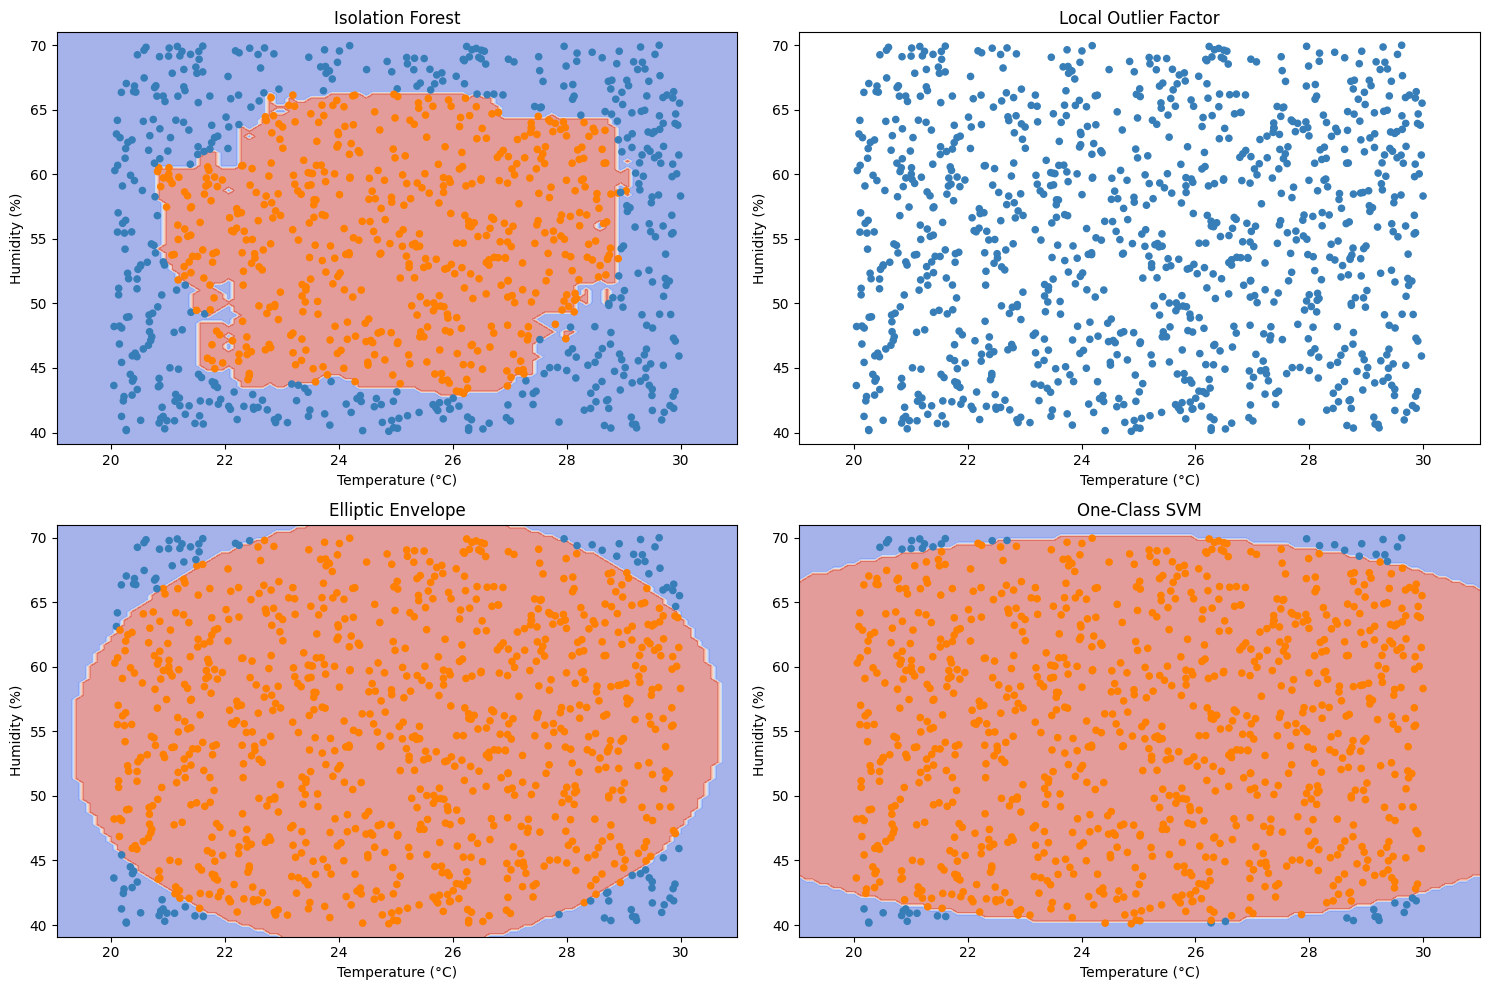

In [32]:
import matplotlib.pyplot as plt
import numpy as np


# Load your data
data = pd.read_csv('data/train_data.csv')
X = data[['Temperature (°C)', 'Humidity (%)']].values

# Define anomaly detection algorithms
anomaly_algorithms = [
    ("Isolation Forest", isof),
    ("Local Outlier Factor", lof),
    ("Elliptic Envelope", elliptic),
    ("One-Class SVM", svm),
]

# Create a mesh grid for plotting decision boundaries
xx, yy = np.meshgrid(np.linspace(X[:, 0].min() - 1, X[:, 0].max() + 1, 100),
                     np.linspace(X[:, 1].min() - 1, X[:, 1].max() + 1, 100))

plt.figure(figsize=(15, 10))

for i, (name, algorithm) in enumerate(anomaly_algorithms):
    plt.subplot(2, 2, i + 1)

    # Fit the algorithm
    if name == "Local Outlier Factor":
        y_pred = algorithm.predict(X)
    else:
        y_pred = algorithm.fit(X).predict(X)

    # Create the decision boundary
    if name != "Local Outlier Factor":
        Z = algorithm.predict(np.c_[xx.ravel(), yy.ravel()])
        Z = Z.reshape(xx.shape)
        plt.contourf(xx, yy, Z, alpha=0.5, cmap='coolwarm')

    # Scatter plot
    colors = np.array(["#377eb8", "#ff7f00"])
    plt.scatter(X[:, 0], X[:, 1], s=20, color=colors[(y_pred + 1) // 2])
    plt.title(name)
    plt.xlabel("Temperature (°C)")
    plt.ylabel("Humidity (%)")
    plt.xlim(X[:, 0].min() - 1, X[:, 0].max() + 1)
    plt.ylim(X[:, 1].min() - 1, X[:, 1].max() + 1)

plt.tight_layout()
plt.show()
